<a href="https://colab.research.google.com/github/Arausi450/Personal_Project/blob/main/LinkedIn_Job_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Decoding the Digital Job Market: An In-Depth Analysis of LinkedIn Postings**

In [112]:
# ---------------------------------------------------------------------------
# LinkedIn Job Postings Analysis
# Author: David ARAUSI
# Date: 2024-08-25
# ---------------------------------------------------------------------------

# STAGE 1: DATA INGESTION

# Objective: Load the dataset into the Google Colab environment.

# Data Source: Kaggle - 'https://www.kaggle.com/datasets/arshkon/linkedin-job-postings'

# Import the 'files' module for file uploads in Colab.
from google.colab import files

# Prompt the user to upload the 'job_postings.zip' file.
# This code is specific to Google Colab and requires user interaction to upload the file.
# In a different environment, data loading would be handled differently (e.g., reading from a local path or cloud storage).
uploaded = files.upload()

Saving job_postings.zip to job_postings.zip


In [115]:
# STAGE 2: ENVIRONMENT SETUP & DATA EXTRACTION

# Objective: Install required libraries and extract data from the zip archive.

# Install necessary Python libraries.
# wordcloud: For creating word clouds.
# matplotlib & seaborn: For static data visualization.
# plotly: For interactive visualizations.
# nltk: For text processing.
# scikit-learn: For machine learning tasks.
# All necessary libraries are already listed and installed, this is good.
!pip install wordcloud matplotlib seaborn plotly nltk scikit-learn

# Import required libraries and modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import zipfile
import os
from datetime import datetime
import re

# Import specific modules for NLP and ML.
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import nltk

# Download necessary NLTK data packages only if they haven't been downloaded.
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')


# Extract data from the zip file.
# The extraction path is well-defined.
with zipfile.ZipFile('job_postings.zip', 'r') as zip_ref:
    zip_ref.extractall('job_postings_data')

# Verify the extracted file structure.
# This verification step is helpful for confirming the data is extracted correctly.
base_path = 'job_postings_data'
for root, dirs, files in os.walk(base_path):
    level = root.replace(base_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f'{subindent}{file}')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


job_postings_data/
  postings.csv
  companies/
    company_industries.csv
    companies.csv
    employee_counts.csv
    company_specialities.csv
  mappings/
    skills.csv
    industries.csv
  jobs/
    benefits.csv
    job_industries.csv
    job_skills.csv
    salaries.csv


In [116]:
# STAGE 3: DATA LOADING

# Objective: Load all raw CSV files into pandas DataFrames.

# Define the base path to the extracted data.
base_path = 'job_postings_data'

# Load each CSV file into a DataFrame.
# low_memory=False is used for safer handling of large files.

# Load core job posting data.
postings = pd.read_csv(f'{base_path}/postings.csv', low_memory=False)

# Load company-related tables.
companies = pd.read_csv(f'{base_path}/companies/companies.csv', low_memory=False)
company_industries = pd.read_csv(f'{base_path}/companies/company_industries.csv', low_memory=False)
company_specialities = pd.read_csv(f'{base_path}/companies/company_specialities.csv', low_memory=False)
employee_counts = pd.read_csv(f'{base_path}/companies/employee_counts.csv', low_memory=False)

# Load job-specific attribute tables.
# These tables provide details about job skills, industries, salaries, and benefits.
skills = pd.read_csv(f'{base_path}/mappings/skills.csv', low_memory=False)
industries = pd.read_csv(f'{base_path}/mappings/industries.csv', low_memory=False)
job_skills = pd.read_csv(f'{base_path}/jobs/job_skills.csv', low_memory=False)
job_industries = pd.read_csv(f'{base_path}/jobs/job_industries.csv', low_memory=False)
salaries = pd.read_csv(f'{base_path}/jobs/salaries.csv', low_memory=False)
benefits = pd.read_csv(f'{base_path}/jobs/benefits.csv', low_memory=False)

print("All raw data files loaded into DataFrames.")

All raw data files loaded into DataFrames.


In [117]:
# STAGE 4: INITIAL DATA EXPLORATION & PROFILING

# Objective: Inspect each DataFrame's structure, size, and missing values.

# Helper function to print key summary statistics for a given DataFrame.
def dataset_info(df, name):
    """
    Prints the shape, columns, and missing value counts for a given DataFrame.
    This is a good practice for quickly understanding the structure and completeness
    of each dataset.
    """
    print(f"=== {name} ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Missing values:\n{df.isnull().sum()}")
    print("\n")

# Collect all loaded DataFrames in a dictionary for easy iteration.
datasets = {
    "Postings": postings,
    "Companies": companies,
    "Skills": skills,
    "Industries": industries,
    "Job Skills": job_skills,
    "Job Industries": job_industries,
    "Salaries": salaries,
    "Benefits": benefits,
    "Company Industries": company_industries,
    "Company Specialities": company_specialities,
    "Employee Counts": employee_counts
}

# Iterate through the datasets and print info using the helper function.
for name, df in datasets.items():
    dataset_info(df, name)

=== Postings ===
Shape: (123849, 31)
Columns: ['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips']
Missing values:
job_id                             0
company_name                    1719
title                              0
description                        7
max_salary                     94056
pay_period                     87776
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies        

In [118]:
# STAGE 5: DEEP DATA INSPECTION & QUALITY ASSESSMENT

# Objective: Conduct detailed data quality checks before cleaning and merging.

# Identify potential join keys by looking for common column names.
# This helps understand how the different tables can be linked.
print("=== KEY COLUMNS FOR JOINING DATASETS ===")
print("Postings columns:", [col for col in postings.columns if 'id' in col.lower() or 'job' in col.lower()])
print("Companies columns:", [col for col in companies.columns if 'id' in col.lower() or 'company' in col.lower()])
print("Skills columns:", [col for col in skills.columns if 'id' in col.lower() or 'skill' in col.lower()])
print("Industries columns:", [col for col in industries.columns if 'id' in col.lower() or 'industry' in col.lower()])
print("Job Skills columns:", [col for col in job_skills.columns if 'id' in col.lower() or 'job' in col.lower() or 'skill' in col.lower()])
print("Job Industries columns:", [col for col in job_industries.columns if 'id' in col.lower() or 'job' in col.lower() or 'industry' in col.lower()])
print("Company Industries columns:", [col for col in company_industries.columns if 'id' in col.lower() or 'company' in col.lower() or 'industry' in col.lower()])
print("Company Specialities columns:", [col for col in company_specialities.columns if 'id' in col.lower() or 'company' in col.lower() or 'specialit' in col.lower()])
print("Employee Counts columns:", [col for col in employee_counts.columns if 'id' in col.lower() or 'company' in col.lower() or 'employee' in col.lower()])

# Check for duplicate records in each dataset.
# Essential for ensuring data integrity before merging.
print("\n=== DUPLICATE CHECK ===")
for name, df in datasets.items():
    duplicates = df.duplicated().sum()
    print(f"{name}: {duplicates} duplicates")

# Verify data types for each column.
# Crucial for correct data manipulation and analysis.
print("\n=== DATA TYPES ===")
for name, df in datasets.items():
    print(f"\n--- {name} ---")
    print(df.dtypes)

=== KEY COLUMNS FOR JOINING DATASETS ===
Postings columns: ['job_id', 'company_id', 'job_posting_url']
Companies columns: ['company_id', 'company_size']
Skills columns: ['skill_abr', 'skill_name']
Industries columns: ['industry_id', 'industry_name']
Job Skills columns: ['job_id', 'skill_abr']
Job Industries columns: ['job_id', 'industry_id']
Company Industries columns: ['company_id', 'industry']
Company Specialities columns: ['company_id', 'speciality']
Employee Counts columns: ['company_id', 'employee_count']

=== DUPLICATE CHECK ===
Postings: 0 duplicates
Companies: 0 duplicates
Skills: 0 duplicates
Industries: 0 duplicates
Job Skills: 0 duplicates
Job Industries: 0 duplicates
Salaries: 0 duplicates
Benefits: 0 duplicates
Company Industries: 0 duplicates
Company Specialities: 0 duplicates
Employee Counts: 0 duplicates

=== DATA TYPES ===

--- Postings ---
job_id                          int64
company_name                   object
title                          object
description     

In [119]:
# STAGE 6: DATA CLEANING AND PREPROCESSING - Part 1

# Objective: Clean and preprocess the dataframes before merging.

print("=== DATA TYPE CORRECTIONS ===")

# Convert 'company_id' in postings to integer, handling NaNs.
# This conversion is necessary for merging with other tables on company_id.
print(f"Postings company_id NaN count: {postings['company_id'].isna().sum()}")
# Creating a boolean column to track missing company_ids before filling NaNs.
postings['company_id_missing'] = postings['company_id'].isna()
# Filling NaN company_ids with -1 and converting to integer.
postings['company_id'] = postings['company_id'].fillna(-1).astype(int)

# Drop rows with missing 'industry_name' in the industries table.
# Rows with missing industry names are not useful for analysis.
print(f"Industries with missing names: {industries['industry_name'].isna().sum()}")
industries = industries.dropna(subset=['industry_name'])

# Convert Unix timestamp columns in postings to datetime objects.
# Converting timestamps to datetime objects is crucial for time-series analysis.
date_columns = ['original_listed_time', 'listed_time', 'expiry', 'closed_time']
for col in date_columns:
    if col in postings.columns:
        # Using errors='coerce' will turn unparseable dates into NaT (Not a Time).
        postings[col] = pd.to_datetime(postings[col], unit='s', errors='coerce')
        print(f"Converted {col} to datetime")

print("\n=== HANDLING MISSING VALUES ===")

# Fill missing values in 'description' and 'company_name' columns.
# Filling missing text data with placeholders prevents errors in text processing.
postings['description'] = postings['description'].fillna('No description available')
postings['company_name'] = postings['company_name'].fillna('Unknown Company')

=== DATA TYPE CORRECTIONS ===
Postings company_id NaN count: 1717
Industries with missing names: 34
Converted original_listed_time to datetime
Converted listed_time to datetime
Converted expiry to datetime
Converted closed_time to datetime

=== HANDLING MISSING VALUES ===


In [120]:
# STAGE 6: DATA CLEANING AND PREPROCESSING - Part 2

# Objective: Create a comprehensive company dataset by merging related tables.

print("\n=== CREATING COMPREHENSIVE COMPANY DATASET ===")

# Map industry names to industry IDs for merging.
industry_name_to_id = dict(zip(industries['industry_name'], industries['industry_id']))

def map_industry_name_to_id(industry_name):
    """Maps an industry name to its ID, returning -1 if not found."""
    # Ensure the industry_name is not NaN before mapping.
    if pd.isna(industry_name):
        return -1
    return industry_name_to_id.get(industry_name, -1)

# Apply the mapping to the 'industry' column in company_industries.
company_industries['industry_id'] = company_industries['industry'].apply(map_industry_name_to_id)

# Merge company-related DataFrames.
# Merge with company_industries on company_id and industry_id.
companies_full = companies.merge(
    company_industries[['company_id', 'industry_id']].drop_duplicates(),
    on='company_id',
    how='left'
).merge(
    # Aggregate company specialities by company_id.
    company_specialities.groupby('company_id')['speciality'].apply(lambda x: ', '.join(x)).reset_index(name='speciality'),
    on='company_id',
    how='left'
).merge(
    # Aggregate employee and follower counts by company_id.
    employee_counts.groupby('company_id').agg({
        'employee_count': 'mean',
        'follower_count': 'mean',
        'time_recorded': 'max' # Use the latest time recorded
    }).reset_index(),
    on='company_id',
    how='left'
)

print(f"Comprehensive company dataset shape: {companies_full.shape}")


=== CREATING COMPREHENSIVE COMPANY DATASET ===
Comprehensive company dataset shape: (24483, 15)


In [123]:
# STAGE 6: DATA CLEANING AND PREPROCESSING - Part 3

# Objective: Create a comprehensive job postings dataset by merging relevant tables.

print("\n=== CREATING COMPREHENSIVE JOB POSTINGS DATASET ===")

# Aggregate Job Skills.
job_skills_full = job_skills.merge(skills, on='skill_abr', how='left')
# Join skills associated with each job into a single string.
skills_by_job = job_skills_full.groupby('job_id')['skill_name'].apply(lambda x: ', '.join(x.dropna())).reset_index()
skills_by_job.columns = ['job_id', 'skills_list']

# Aggregate Job Industries.
job_industries_full = job_industries.merge(industries, on='industry_id', how='left')
# Join industries associated with each job into a single string.
industries_by_job = job_industries_full.groupby('job_id')['industry_name'].apply(lambda x: ', '.join(x.dropna())).reset_index()
industries_by_job.columns = ['job_id', 'industries_list']

# Aggregate Job Benefits.
# Join benefits associated with each job into a single string.
benefits_by_job = benefits.groupby('job_id')['type'].apply(lambda x: ', '.join(x.dropna())).reset_index()
benefits_by_job.columns = ['job_id', 'benefits_list']

# Merge postings with aggregated data.
# Perform a series of left merges to combine job postings with skills, industries, salaries, benefits, and company information.
postings_full = postings.merge(
    skills_by_job,
    on='job_id',
    how='left'
).merge(
    industries_by_job,
    on='job_id',
    how='left'
).merge(
    # Use salaries table for complete salary info, adding a suffix to distinguish from original postings columns.
    salaries[['job_id', 'max_salary', 'min_salary', 'med_salary', 'pay_period', 'currency', 'compensation_type']],
    on='job_id',
    how='left',
    suffixes=('', '_salary')
).merge(
    benefits_by_job,
    on='job_id',
    how='left'
).merge(
    companies_full,
    on='company_id',
    how='left',
    # Add suffixes to distinguish columns originating from the job postings and company dataframes.
    suffixes=('_job', '_company')
)

print(f"Comprehensive postings dataset shape: {postings_full.shape}")
print(f"Comprehensive postings dataset columns: {list(postings_full.columns)}")

# --- Handling Missing Values and Standardizing Salary (Moved from STAGE 7) ---

print("\n=== HANDLING MISSING VALUES AND STANDARDIZING SALARY ===")

# Fill missing 'skills_list' and 'industries_list'.
# Filling with 'Not specified' provides a category for these missing values.
postings_full['skills_list'] = postings_full['skills_list'].fillna('Not specified')
postings_full['industries_list'] = postings_full['industries_list'].fillna('Not specified')
print("Filled missing values in 'skills_list' and 'industries_list'.")

# Standardize Salary Information.
# Create a calculated average salary from min and max salary columns.
postings_full['calculated_avg_salary'] = postings_full[['min_salary_salary', 'max_salary_salary']].mean(axis=1)

# Function to convert salaries to annual equivalent.
def standardize_salary(row):
    """Converts salaries to an annual equivalent based on pay period."""
    salary = row['calculated_avg_salary']
    pay_period = row['pay_period_salary'] # Use the pay_period from salaries table

    # Return None for rows with missing salary or pay period.
    if pd.isna(salary) or pd.isna(pay_period):
        return None

    # Convert salary based on pay period.
    if pay_period == 'HOURLY':
        # Assuming a 40-hour work week and 52 weeks a year.
        return salary * 40 * 52
    elif pay_period == 'MONTHLY':
        return salary * 12
    elif pay_period == 'YEARLY':
        return salary
    else:
        # Return None for unknown pay periods.
        return None

# Apply function to create standardized annual salary.
postings_full['annual_salary'] = postings_full.apply(standardize_salary, axis=1)

print("\n--- Post-Handling Data Quality Check ---")
print(f"Missing values in 'skills_list' after handling: {postings_full['skills_list'].isna().sum()}")
print(f"Missing values in 'industries_list' after handling: {postings_full['industries_list'].isna().sum()}")
non_null_annual = postings_full['annual_salary'].notna().sum()
print(f"Non-null values in 'annual_salary': {non_null_annual} ({non_null_annual/len(postings_full)*100:.2f}%)")

print("\nData cleaning and preprocessing complete!")


=== CREATING COMPREHENSIVE JOB POSTINGS DATASET ===
Comprehensive postings dataset shape: (123996, 55)
Comprehensive postings dataset columns: ['job_id', 'company_name', 'title', 'description_job', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code_job', 'fips', 'company_id_missing', 'skills_list', 'industries_list', 'max_salary_salary', 'min_salary_salary', 'med_salary_salary', 'pay_period_salary', 'currency_salary', 'compensation_type_salary', 'benefits_list', 'name', 'description_company', 'company_size', 'state', 'country', 'city', 'zip_code_company', 'address', 'url', 'industry_id', 'speciality', 'employee_count', 'foll

In [122]:
# STAGE 7: FINAL DATA QUALITY CHECK

# Objective: Perform a final check of the merged dataset for missing values in key columns.

print("\n=== FINAL DATA QUALITY CHECK ===")

# Check missing values in key text columns.
# It's important to see how many missing values remain after merging and filling.
print("Missing values in key columns:")
key_columns = ['title', 'description_job', 'company_name', 'skills_list', 'industries_list']
for col in key_columns:
    if col in postings_full.columns:
        missing = postings_full[col].isna().sum()
        print(f"{col}: {missing} missing values ({missing/len(postings_full)*100:.2f}%)")

# Check non-null values for salary columns.
# Assessing the completeness of salary data is crucial for salary analysis.
print("\nNon-null salary values:")
salary_cols = ['max_salary_salary', 'min_salary_salary', 'med_salary_salary']
for col in salary_cols:
    if col in postings_full.columns:
        non_null = postings_full[col].notna().sum()
        print(f"{col}: {non_null} non-null values ({non_null/len(postings_full)*100:.2f}%)")

print("\nData cleaning and preprocessing complete!")


=== FINAL DATA QUALITY CHECK ===
Missing values in key columns:
title: 0 missing values (0.00%)
description_job: 0 missing values (0.00%)
company_name: 0 missing values (0.00%)
skills_list: 1753 missing values (1.41%)
industries_list: 1436 missing values (1.16%)

Non-null salary values:
max_salary_salary: 29859 non-null values (24.08%)
min_salary_salary: 29859 non-null values (24.08%)
med_salary_salary: 6282 non-null values (5.07%)

Data cleaning and preprocessing complete!


/tmp/ipython-input-3774186814.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-3774186814.py:39: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-3774186814.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




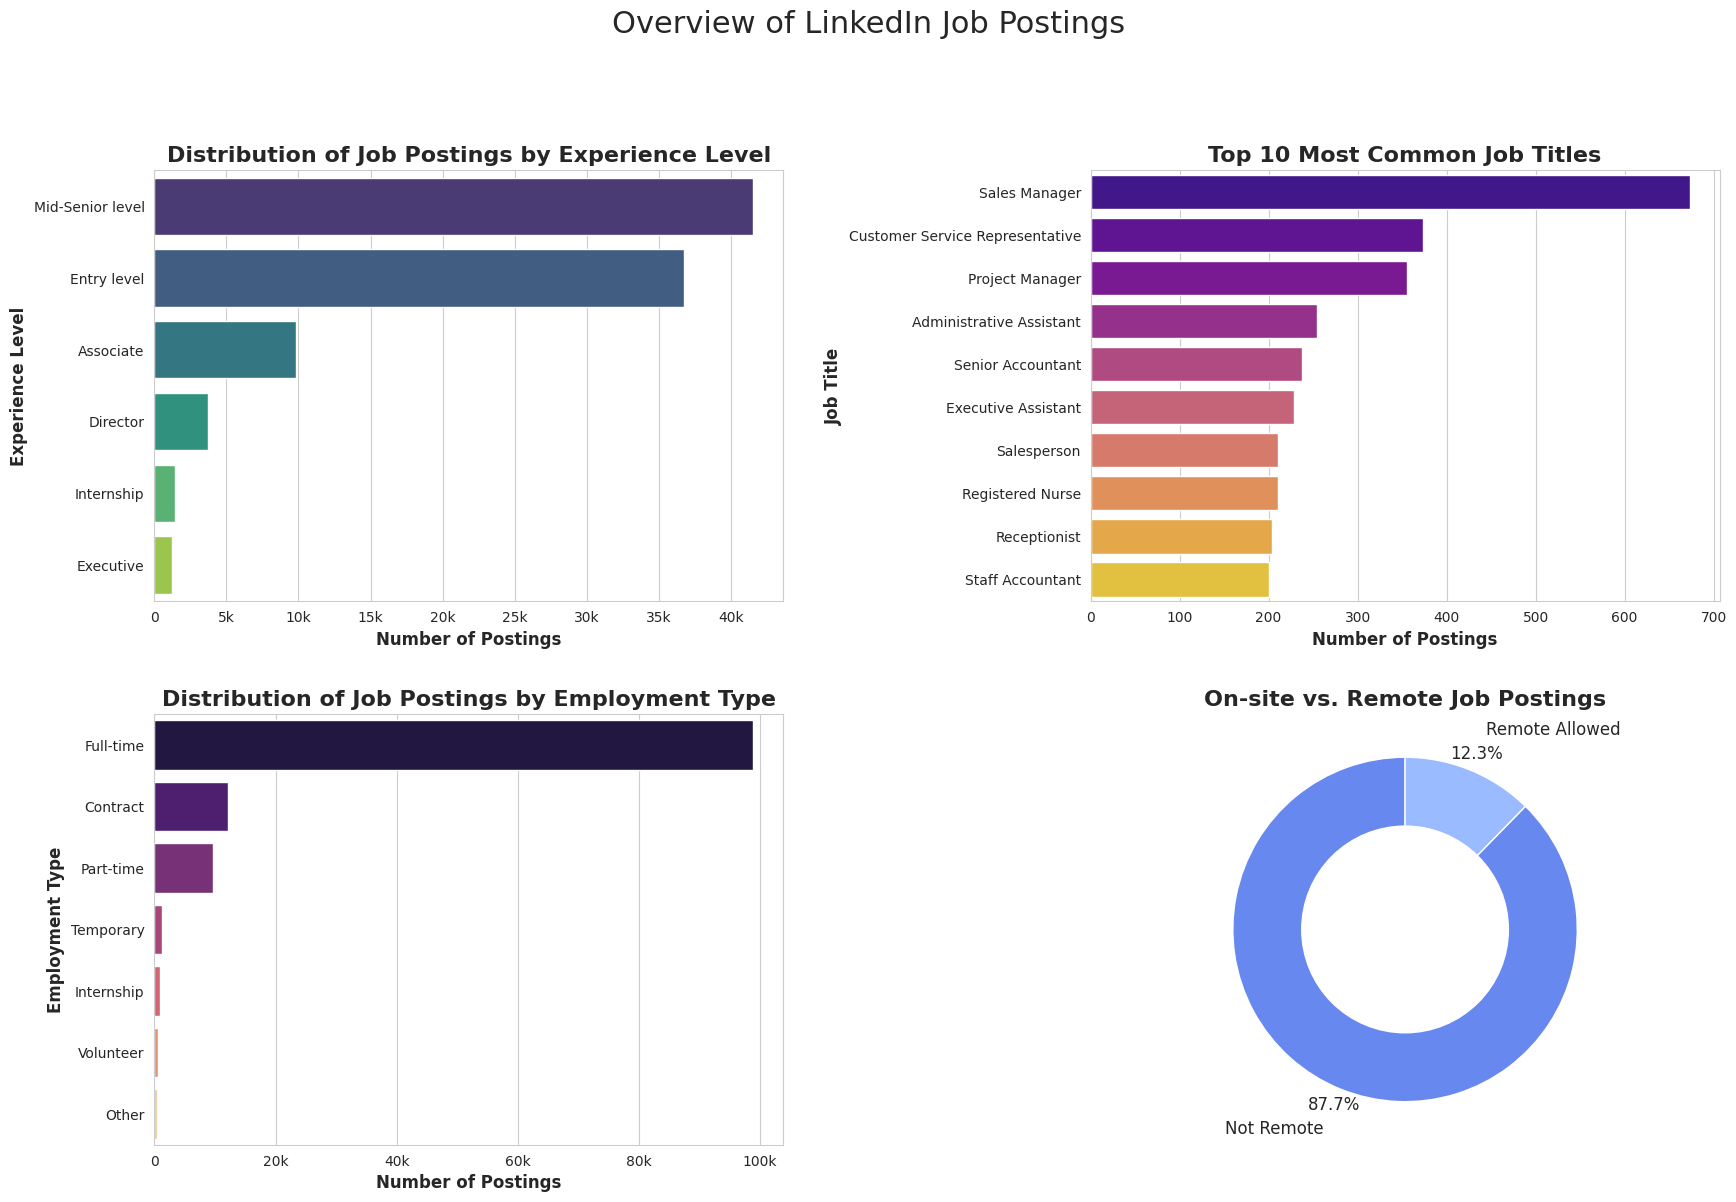

In [127]:
# Exploratory Data Analysis (EDA) - Part 1

# Import number formatter for plot axes.
from matplotlib.ticker import FuncFormatter

# Set plot style.
sns.set_style("whitegrid")
plt.figure(figsize=(18, 12))

# Custom number formatter for 'k' (thousands).
def k_formatter(x, pos):
    """Formats numbers to a short scale (e.g., 40,000 -> 40k)"""
    if x >= 1000:
        return f'{x/1000:,.0f}k'
    return f'{x:,.0f}'

# 1. Distribution of Job Postings by Experience Level.
plt.subplot(2, 2, 1)
exp_level_col = 'formatted_experience_level'
if exp_level_col in postings_full.columns:
    plot_data = postings_full.dropna(subset=[exp_level_col])
    if not plot_data.empty and plot_data[exp_level_col].nunique() > 1: # Add check for unique values
        ax1 = sns.countplot(y=exp_level_col, data=plot_data, order=plot_data[exp_level_col].value_counts().index, palette='viridis')
        plt.title('Distribution of Job Postings by Experience Level', fontsize=16)
        plt.xlabel('Number of Postings', fontsize=12)
        plt.ylabel('Experience Level', fontsize=12)
        ax1.xaxis.set_major_formatter(FuncFormatter(k_formatter))
    else:
        plt.text(0.5, 0.5, 'Not enough data for experience level plot.', ha='center')
        plt.title('Experience Level Data Not Available')
else:
    plt.text(0.5, 0.5, 'Experience Level column not found.', ha='center')
    plt.title('Experience Level Data Not Available')

# 2. Top 10 Most Common Job Titles.
plt.subplot(2, 2, 2)
top_10_titles = postings_full['title'].value_counts().nlargest(10)
if not top_10_titles.empty and len(top_10_titles) > 1: # Add check for number of values
    ax2 = sns.barplot(x=top_10_titles.values, y=top_10_titles.index, palette='plasma')
    plt.title('Top 10 Most Common Job Titles', fontsize=16)
    plt.xlabel('Number of Postings', fontsize=12)
    plt.ylabel('Job Title', fontsize=12)
    ax2.xaxis.set_major_formatter(FuncFormatter(k_formatter))
else:
    plt.text(0.5, 0.5, 'Not enough data for job titles plot.', ha='center')
    plt.title('Job Title Data Not Available')


# 3. Distribution of Job Postings by Employment Type.
plt.subplot(2, 2, 3)
emp_type_col = 'formatted_work_type'
if emp_type_col in postings_full.columns:
    plot_data_emp = postings_full.dropna(subset=[emp_type_col])
    if not plot_data_emp.empty and plot_data_emp[emp_type_col].nunique() > 1: # Add check for unique values
        ax3 = sns.countplot(y=emp_type_col, data=plot_data_emp, order=plot_data_emp[emp_type_col].value_counts().index, palette='magma')
        plt.title('Distribution of Job Postings by Employment Type', fontsize=16)
        plt.xlabel('Number of Postings', fontsize=12)
        plt.ylabel('Employment Type', fontsize=12)
        ax3.xaxis.set_major_formatter(FuncFormatter(k_formatter))
    else:
        plt.text(0.5, 0.5, 'Not enough data for employment type plot.', ha='center')
        plt.title('Employment Type Data Not Available')
else:
    plt.text(0.5, 0.5, 'Employment Type column not found.', ha='center')
    plt.title('Employment Type Data Not Available')

# 4. Distribution of On-site vs. Remote Jobs (Donut Chart).
plt.subplot(2, 2, 4)
remote_col = 'remote_allowed'
if remote_col in postings_full.columns:
    remote_labels = postings_full[remote_col].apply(lambda x: 'Remote Allowed' if x == 1.0 else 'Not Remote')
    remote_counts = remote_labels.value_counts()

    if not remote_counts.empty and len(remote_counts) > 1: # Add check for number of values
        plt.pie(remote_counts, labels=remote_counts.index, autopct='%1.1f%%',
                colors=sns.color_palette('coolwarm'), startangle=90,
                textprops={'fontsize': 12}, pctdistance=1.1, labeldistance=1.25)

        centre_circle = plt.Circle((0, 0), 0.60, fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)

        plt.title('On-site vs. Remote Job Postings', fontsize=16)
    else:
        plt.text(0.5, 0.5, 'Not enough data for remote vs. on-site plot.', ha='center')
        plt.title('On-site vs. Remote Data Not Available')
else:
    plt.text(0.5, 0.5, 'Remote column not found.', ha='center')
    plt.title('Remote Data Not Available')

# Add main title.
plt.suptitle('Overview of LinkedIn Job Postings', fontsize=22, y=1.02)
plt.tight_layout(pad=3.0)
plt.show()

/tmp/ipython-input-1531498760.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




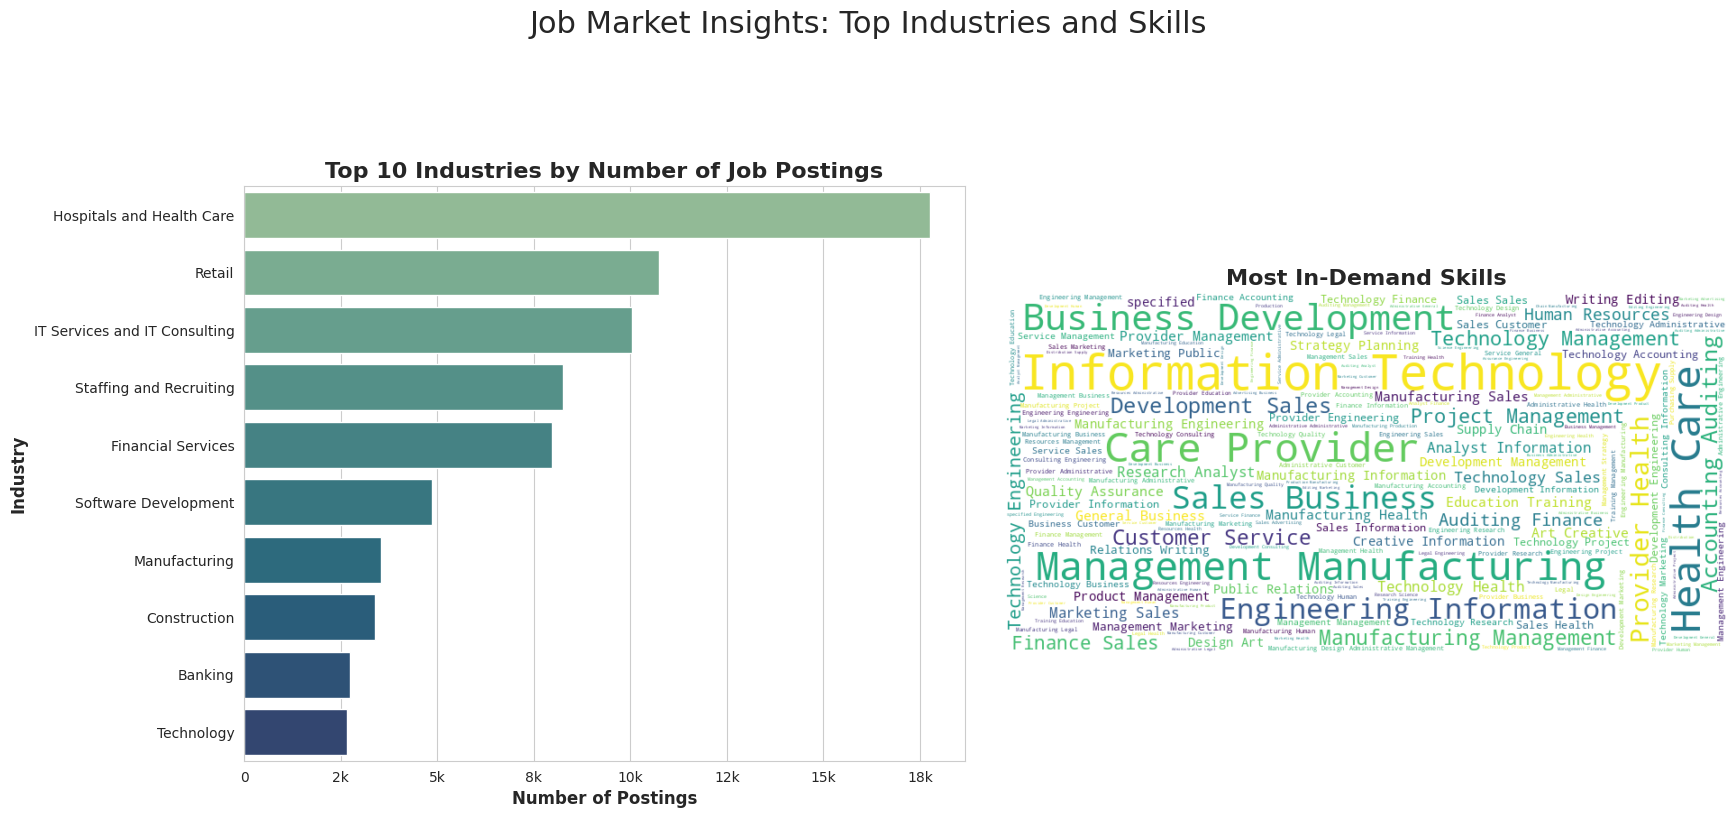

In [128]:
# Exploratory Data Analysis (EDA) - Part 2: Industries and Skills

# Set plot style.
sns.set_style("whitegrid")
plt.figure(figsize=(18, 8))

# 1. Top 10 Industries with the Most Job Postings.
plt.subplot(1, 2, 1)
top_industries = postings_full['industries_list'].str.split(', ').explode().value_counts().nlargest(10)
# Add check for empty series before plotting.
if not top_industries.empty and len(top_industries) > 1:
    sns.barplot(x=top_industries.values, y=top_industries.index, palette='crest')
    plt.title('Top 10 Industries by Number of Job Postings', fontsize=16)
    plt.xlabel('Number of Postings', fontsize=12)
    plt.ylabel('Industry', fontsize=12)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(k_formatter))
else:
    plt.text(0.5, 0.5, 'Not enough data for top industries plot.', ha='center')
    plt.title('Top 10 Industries Data Not Available')


# 2. Word Cloud of Most In-Demand Skills.
plt.subplot(1, 2, 2)
# Ensure there's data for the word cloud.
skills_text = ' '.join(postings_full['skills_list'].dropna())
if skills_text: # Check if the string is not empty
    # Generate word cloud.
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(skills_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most In-Demand Skills', fontsize=16)
else:
    plt.text(0.5, 0.5, 'No skill data for word cloud.', ha='center')
    plt.title('Most In-Demand Skills Data Not Available')


# Adjust layout and add main title.
plt.suptitle('Job Market Insights: Top Industries and Skills', fontsize=22, y=1.05)
plt.tight_layout(pad=3.0)
plt.show()

/tmp/ipython-input-3832822426.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




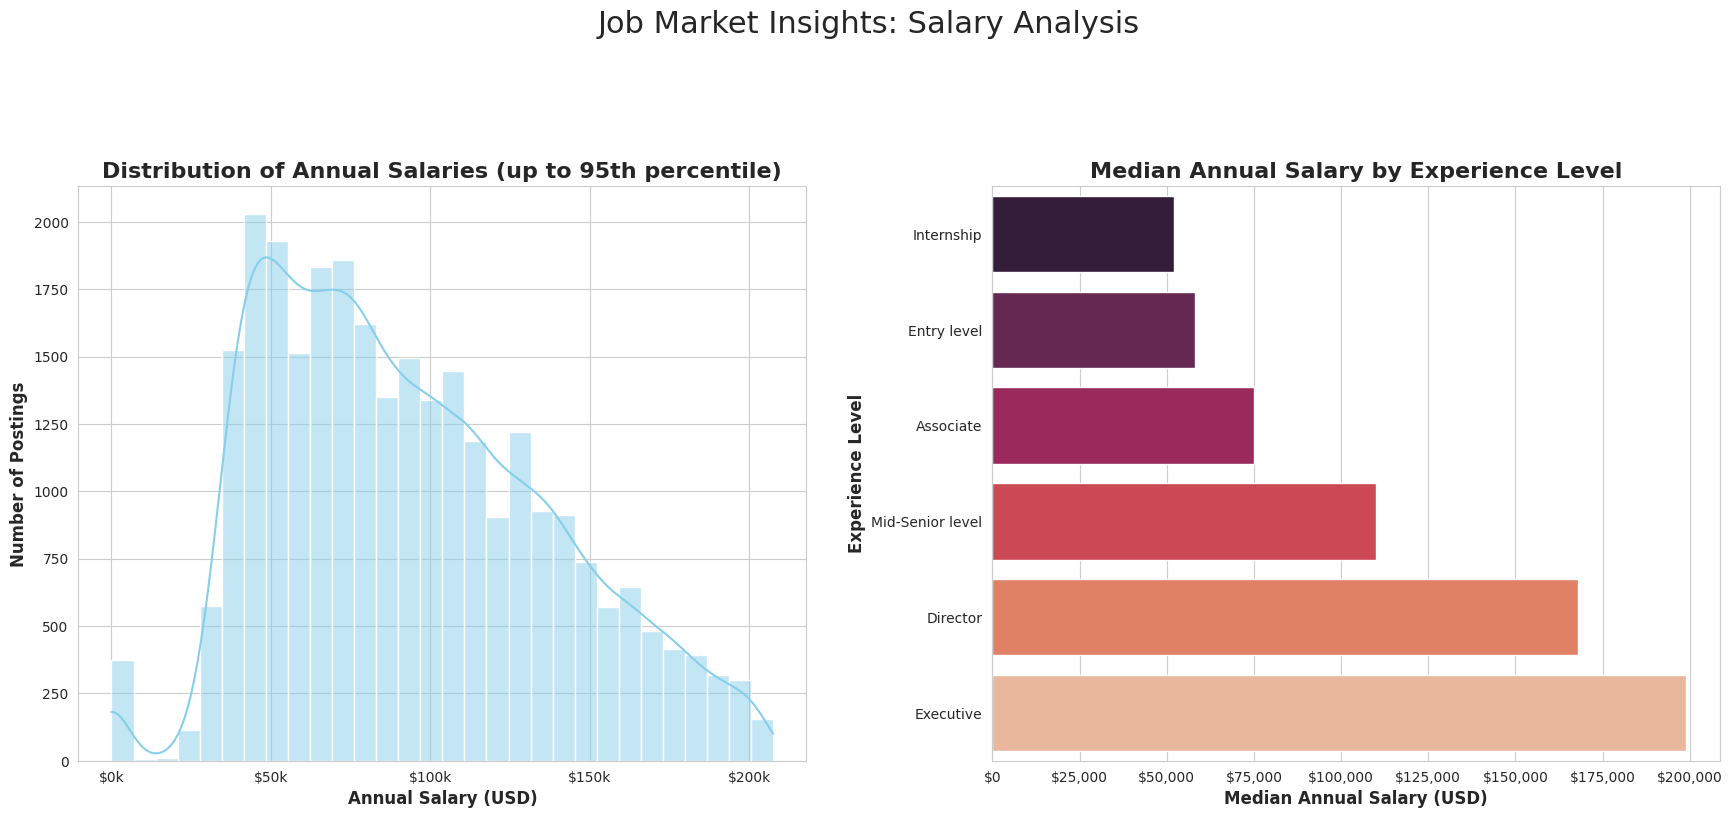

In [129]:
# Exploratory Data Analysis (EDA) - Part 3: Salary Analysis

# Set plot style.
sns.set_style("whitegrid")
plt.figure(figsize=(18, 8))

# 1. Distribution of Annual Salaries.
plt.subplot(1, 2, 1)
# Cap salary at 95th percentile for better visualization.
salary_data = postings_full['annual_salary'].dropna()
if not salary_data.empty: # Add check for empty series
    quantile_95 = salary_data.quantile(0.95)
    sns.histplot(salary_data[salary_data < quantile_95], bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Annual Salaries (up to 95th percentile)', fontsize=16)
    plt.xlabel('Annual Salary (USD)', fontsize=12)
    plt.ylabel('Number of Postings', fontsize=12)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${x/1000:,.0f}k'))
else:
    plt.text(0.5, 0.5, 'No salary data for distribution plot.', ha='center')
    plt.title('Salary Distribution Data Not Available')

# 2. Median Salary by Experience Level.
plt.subplot(1, 2, 2)
median_salary_exp = postings_full.groupby('formatted_experience_level')['annual_salary'].median().dropna().sort_values()
if not median_salary_exp.empty and len(median_salary_exp) > 1: # Add check for number of values
    sns.barplot(x=median_salary_exp.values, y=median_salary_exp.index, palette='rocket')
    plt.title('Median Annual Salary by Experience Level', fontsize=16)
    plt.xlabel('Median Annual Salary (USD)', fontsize=12)
    plt.ylabel('Experience Level', fontsize=12)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'${y:,.0f}')) # Changed formatter to lambda y, pos
else:
    plt.text(0.5, 0.5, 'Not enough data for median salary by experience level plot.', ha='center')
    plt.title('Median Salary by Experience Level Data Not Available')


# Adjust layout and add main title.
plt.suptitle('Job Market Insights: Salary Analysis', fontsize=22, y=1.05)
plt.tight_layout(pad=3.0)
plt.show()

/tmp/ipython-input-723344632.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-723344632.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-723344632.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




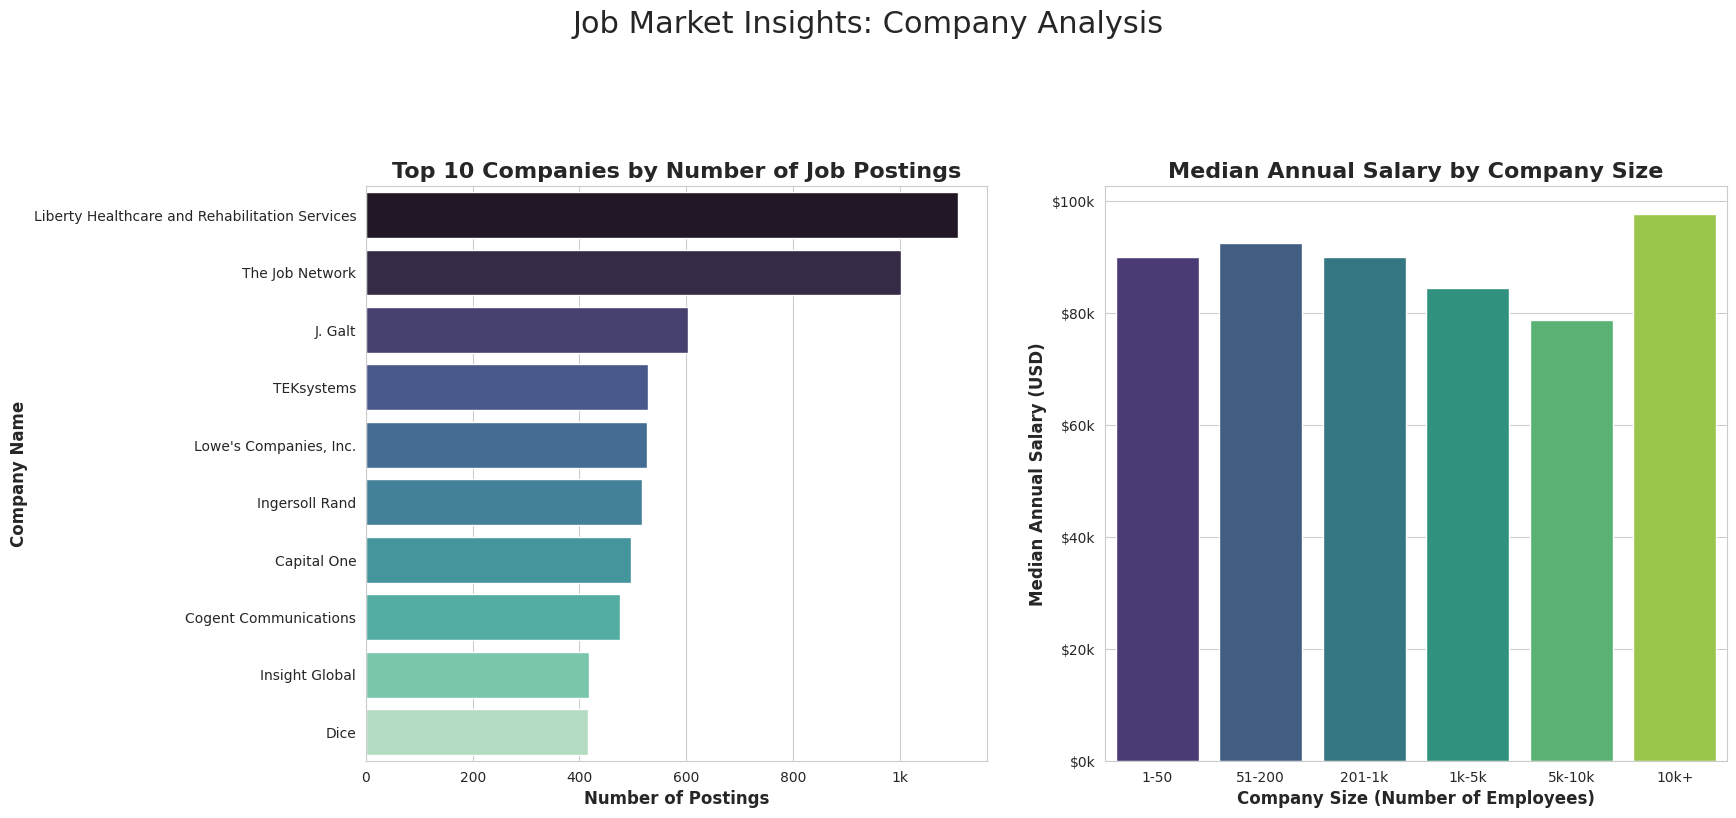

In [130]:
# Exploratory Data Analysis (EDA) - Part 4: Company Analysis

# Set plot style.
sns.set_style("whitegrid")
plt.figure(figsize=(18, 8))

# 1. Top 10 Companies with the Most Job Postings.
plt.subplot(1, 2, 1)
known_companies = postings_full[postings_full['company_name'] != 'Unknown Company']
top_companies = known_companies['company_name'].value_counts().nlargest(10)
sns.barplot(x=top_companies.values, y=top_companies.index, palette='mako')
plt.title('Top 10 Companies by Number of Job Postings', fontsize=16)
plt.xlabel('Number of Postings', fontsize=12)
plt.ylabel('Company Name', fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(k_formatter))

# 2. Median Salary by Company Size.
plt.subplot(1, 2, 2)
# Categorize company size.
bins = [0, 50, 200, 1000, 5000, 10000, float('inf')]
labels = ['1-50', '51-200', '201-1k', '1k-5k', '5k-10k', '10k+']
postings_full['company_size_category'] = pd.cut(postings_full['employee_count'], bins=bins, labels=labels, right=False)

# Calculate median salary by company size category.
median_salary_size = postings_full.groupby('company_size_category')['annual_salary'].median().dropna()
sns.barplot(x=median_salary_size.index, y=median_salary_size.values, palette='viridis')
plt.title('Median Annual Salary by Company Size', fontsize=16)
plt.xlabel('Company Size (Number of Employees)', fontsize=12)
plt.ylabel('Median Annual Salary (USD)', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'${y/1000:,.0f}k'))

# Adjust layout and add main title.
plt.suptitle('Job Market Insights: Company Analysis', fontsize=22, y=1.05)
plt.tight_layout(pad=3.0)
plt.show()

/tmp/ipython-input-4157930707.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




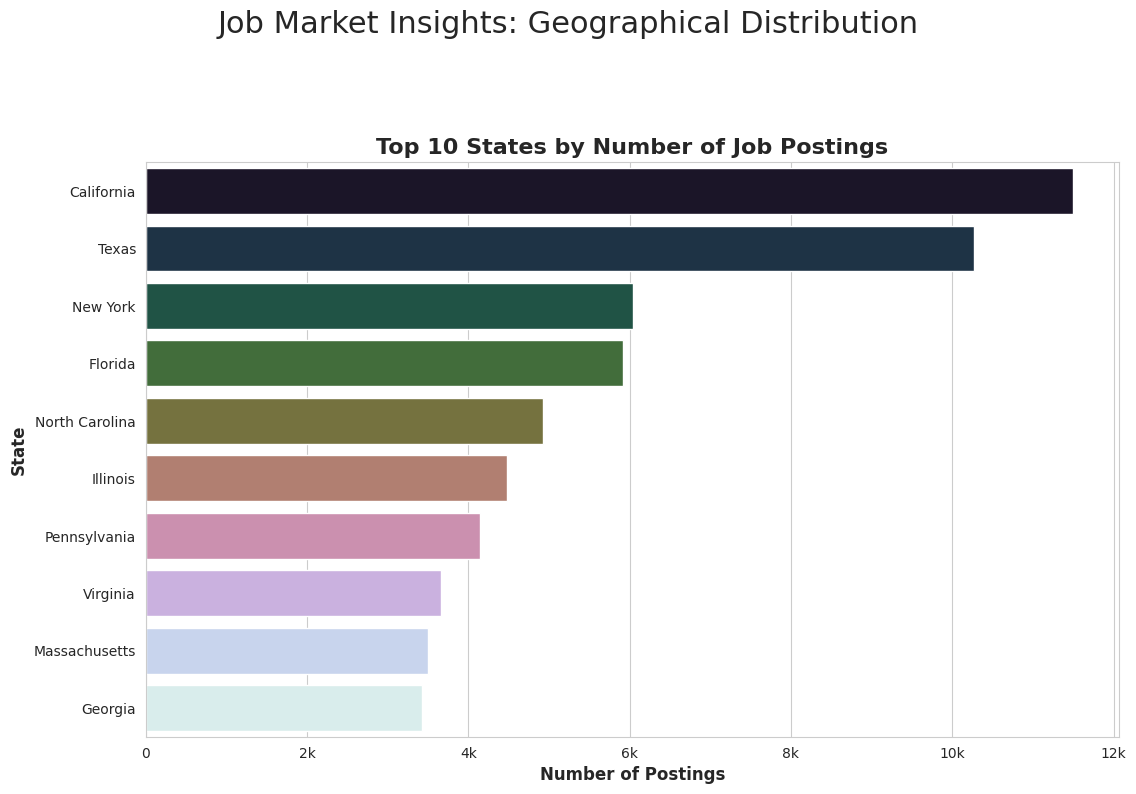

In [131]:
# Exploratory Data Analysis (EDA) - Part 5: Geographical Analysis

# Set plot style.
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Top 10 Locations with the Most Job Postings.
# Map US state abbreviations to full names.
state_map = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire',
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
    'DC': 'District of Columbia', 'PR': 'Puerto Rico'
}

# Extract state from location and filter US states.
postings_full['state'] = postings_full['location'].str.split(', ').str[-1]
us_states_only = postings_full[postings_full['state'].isin(state_map.keys())] # Filter using keys

# Count job postings by state.
top_locations = us_states_only['state'].value_counts().nlargest(10)

# Map abbreviations to full names for plotting.
top_locations.index = [state_map.get(abbr, abbr) for abbr in top_locations.index]

sns.barplot(x=top_locations.values, y=top_locations.index, palette='cubehelix')
plt.title('Top 10 States by Number of Job Postings', fontsize=16)
plt.xlabel('Number of Postings', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(k_formatter))

# Adjust layout and add main title.
plt.suptitle('Job Market Insights: Geographical Distribution', fontsize=22, y=1.02)
plt.tight_layout(pad=3.0)
plt.show()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/tmp/ipython-input-8184838.py:56: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




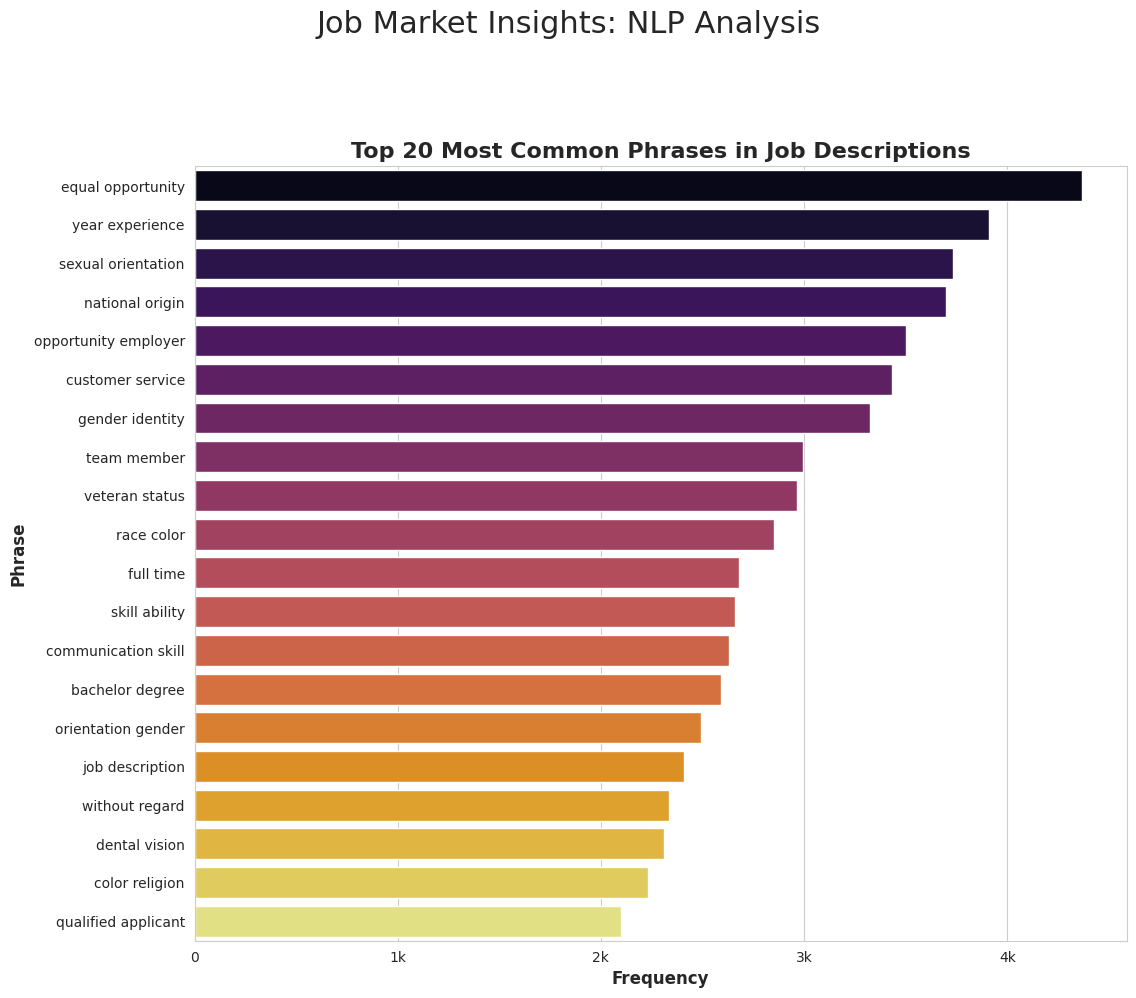

In [132]:
# Natural Language Processing (NLP) on Job Descriptions

# Import necessary libraries for text processing.
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Ensure necessary NLTK data is downloaded.
# These downloads are necessary for NLP.
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')


# Text Preprocessing.
# Use a sample of the data for manageable processing.
df_sample = postings_full.sample(10000, random_state=42)

# Initialize lemmatizer and stopwords.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Cleans and prepares text for NLP."""
    text = str(text) # Ensure text is a string
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(lemmatized_words)

# Apply preprocessing to job descriptions.
df_sample['processed_description'] = df_sample['description_job'].apply(preprocess_text)

# Bigram Analysis (Two-Word Phrases).
vectorizer = CountVectorizer(ngram_range=(2, 2))
bigram_matrix = vectorizer.fit_transform(df_sample['processed_description'])
bigram_counts = bigram_matrix.sum(axis=0)
bigrams_freq = [(word, bigram_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
sorted_bigrams = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)

# Visualization of top bigrams.
top_20_bigrams = pd.DataFrame(sorted_bigrams[:20], columns=['bigram', 'count'])

plt.figure(figsize=(12, 10))
sns.barplot(x='count', y='bigram', data=top_20_bigrams, palette='inferno')
plt.title('Top 20 Most Common Phrases in Job Descriptions', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Phrase', fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(k_formatter))

plt.suptitle('Job Market Insights: NLP Analysis', fontsize=22, y=1.02)
plt.tight_layout(pad=3.0)
plt.show()

--- Model Performance ---
Mean Absolute Error (MAE): $920,546.61
R-squared (R²): -0.00

Model training and evaluation complete!


/tmp/ipython-input-2613591393.py:74: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




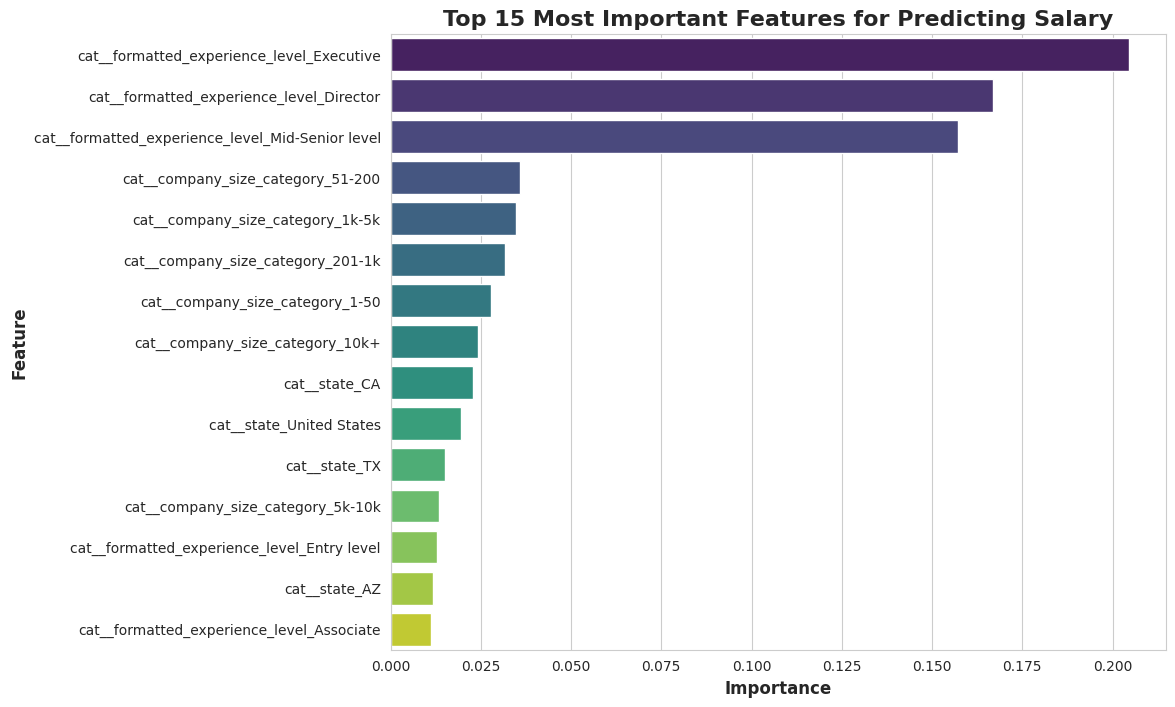

In [133]:
# Machine Learning - Predicting Annual Salary

# Import necessary libraries for machine learning.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for plotting


# Feature Selection and Data Preparation.
features = [
    'formatted_experience_level',
    'company_size_category',
    'state',
    'remote_allowed'
]
target = 'annual_salary'

# Create DataFrame with selected features and target, dropping NaNs.
df_model = postings_full[features + [target]].dropna()

# Identify categorical columns.
categorical_features = df_model.select_dtypes(include=['object', 'category']).columns

# Create Preprocessing and Modeling Pipeline.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Define the model.
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Create the full pipeline.
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

# Split Data, Train Model, and Evaluate.
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model.
pipeline.fit(X_train, y_train)

# Make predictions.
y_pred = pipeline.predict(X_test)

# Evaluate performance.
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Model Performance ---")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"R-squared (R²): {r2:.2f}")
print("\nModel training and evaluation complete!")

# Feature Importance.
# Ensure feature_names are correctly obtained after fitting the preprocessor.
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=features)

importances = pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(15)

# Plot important features.
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 15 Most Important Features for Predicting Salary', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

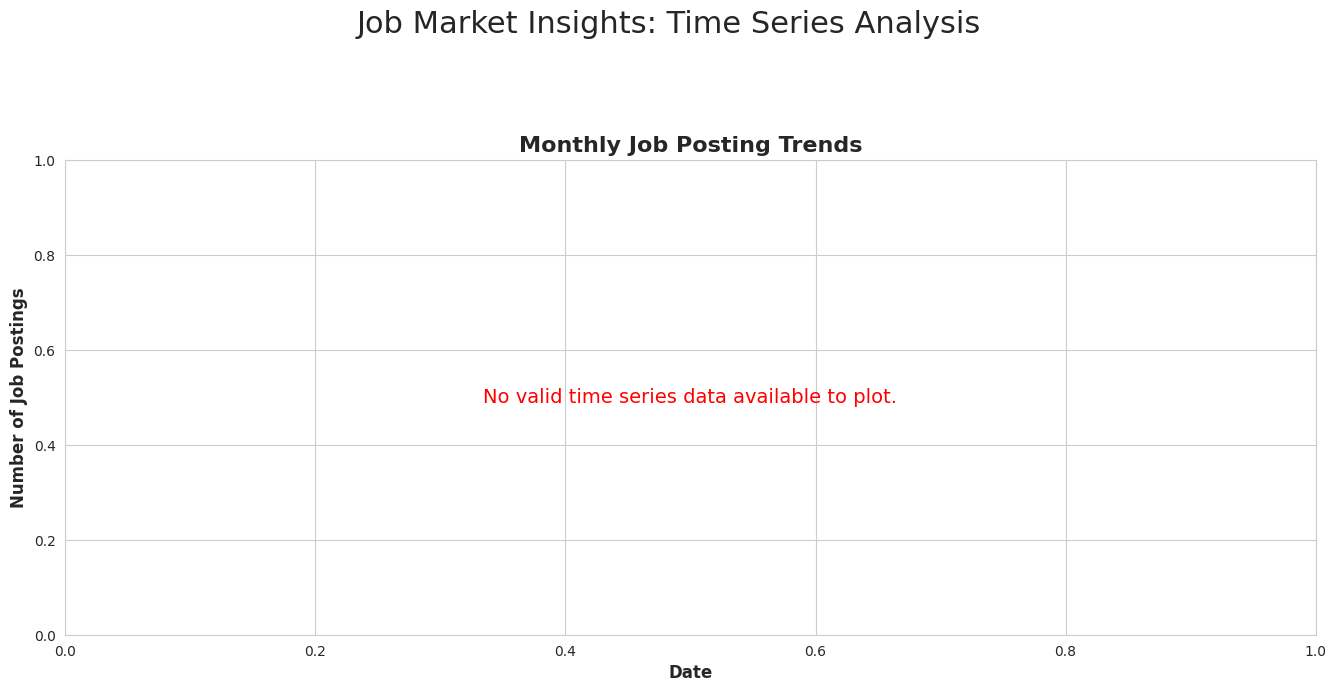

In [134]:
# Time Series Analysis - Job Posting Trends Over Time

# Data Preparation for Time Series.
# Use 'listed_time' and ensure datetime format.
df_time = postings_full[['listed_time']].dropna()
df_time['listed_time'] = pd.to_datetime(df_time['listed_time'])
df_time = df_time.set_index('listed_time')

# Resample Data by Month.
monthly_postings = df_time.resample('ME').size()

# Visualization.
plt.figure(figsize=(14, 7))

if not monthly_postings.empty:
    monthly_postings.plot(kind='line', marker='o', linestyle='-', color='teal')

    plt.title('Monthly Job Posting Trends', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Job Postings', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(k_formatter))
else:
    plt.text(0.5, 0.5, 'No valid time series data available to plot.',
             horizontalalignment='center', verticalalignment='center',
             fontsize=14, color='red')
    plt.title('Monthly Job Posting Trends', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Job Postings', fontsize=12)

plt.suptitle('Job Market Insights: Time Series Analysis', fontsize=22, y=1.02)
plt.tight_layout(pad=3.0)
plt.show()

--- Top Terms per Cluster ---
Cluster 0: project, design, data, engineering, team, technical, development, management, software, engineer
Cluster 1: sale, business, customer, client, team, marketing, financial, accounting, product, management
Cluster 2: store, customer, sale, merchandise, associate, retail, manager, product, service, company
Cluster 3: job, service, employee, customer, required, position, company, time, team, ability
Cluster 4: patient, care, nursing, nurse, health, healthcare, medical, clinical, physician, hospital


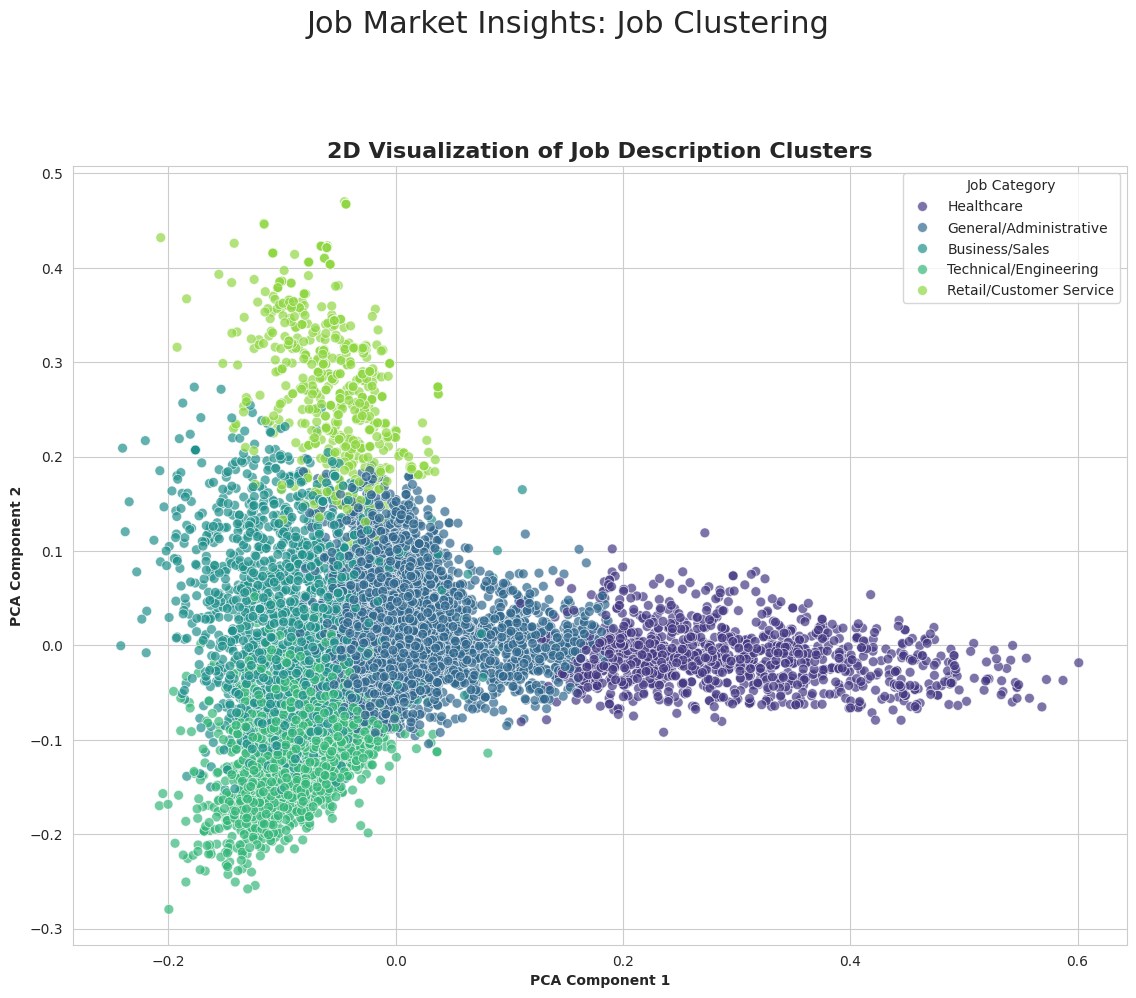

In [135]:
# Unsupervised ML - Clustering Similar Job Descriptions

# Import necessary libraries.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation.
# Use preprocessed text from NLP analysis.
if 'processed_description' not in df_sample.columns:
    print("Preprocessing text data... please wait.")
    # Re-run preprocessing if needed.
    df_sample['processed_description'] = df_sample['description_job'].apply(preprocess_text)

# TF-IDF Vectorization.
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['processed_description'])

# K-Means Clustering.
# Using a fixed number of clusters (5) for demonstration.
# In a real-world scenario, you might use methods like the elbow method
# or silhouette score to determine an optimal number of clusters.
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(tfidf_matrix)

# Add cluster labels to DataFrame.
df_sample['cluster'] = kmeans.labels_

# Analyze and Visualize Clusters.
print("--- Top Terms per Cluster ---")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

# 2D Visualization of Clusters using PCA.
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray())

# Create DataFrame for plotting.
plot_df = pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1], 'cluster': df_sample['cluster']})

# Create meaningful labels for legend.
# These labels are based on the top terms found in each cluster.
cluster_map = {
    0: 'Technical/Engineering',
    1: 'Business/Sales',
    2: 'Retail/Customer Service',
    3: 'General/Administrative',
    4: 'Healthcare'
}
plot_df['cluster_label'] = plot_df['cluster'].map(cluster_map)

# Plot clusters.
plt.figure(figsize=(12, 10))
sns.scatterplot(x='x', y='y', hue='cluster_label', data=plot_df, palette='viridis', alpha=0.7, s=50)
plt.title('2D Visualization of Job Description Clusters', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Job Category')
plt.grid(True)

plt.suptitle('Job Market Insights: Job Clustering', fontsize=22, y=1.02)
plt.tight_layout(pad=3.0)
plt.show()

In [136]:
# Interactive Dashboard for Job Market Insights

# Import necessary libraries for interactive plotting.
import plotly.graph_objects as go
from ipywidgets import Dropdown, VBox

# Prepare Data for the Dashboard.
# Use the main 'postings_full' DataFrame.

# Define comprehensive map of US state abbreviations to full names.
state_map = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire',
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
    'DC': 'District of Columbia', 'PR': 'Puerto Rico'
}
valid_states = list(state_map.keys())

# Filter unique states in data to include only valid abbreviations.
actual_states_in_data = postings_full[postings_full['state'].isin(valid_states)]['state'].dropna().unique()

# Create list for dropdown, including 'All States'.
state_list = ['All States'] + sorted(list(actual_states_in_data))

# Create Initial Figures as FigureWidgets.
# Chart 1: Median Salary by Experience Level.
initial_salary_data = postings_full.groupby('formatted_experience_level')['annual_salary'].median().dropna().sort_values()
fig1 = go.FigureWidget(go.Bar(
    x=initial_salary_data.values,
    y=initial_salary_data.index,
    orientation='h',
    marker_color='purple'
))
fig1.update_layout(
    title_text='Median Salary by Experience Level in All States',
    xaxis_title='Median Annual Salary (USD)',
    yaxis_title='Experience Level',
    height=400
)

# Chart 2: Top Industries.
initial_industry_data = postings_full['industries_list'].str.split(', ').explode().value_counts().nlargest(10)
fig2 = go.FigureWidget(go.Bar(
    x=initial_industry_data.values,
    y=initial_industry_data.index,
    orientation='h',
    marker_color='orange'
))
fig2.update_layout(
    title_text='Top 10 Industries in All States',
    xaxis_title='Number of Postings',
    yaxis_title='Industry',
    yaxis={'autorange': 'reversed'},
    height=400
)

# Create the Dropdown Widget.
state_dropdown = Dropdown(options=state_list, description='Select State:')

# Define the Function to Update the Charts.
def update_charts(change):
    selected_state = change.new

    # Filter data based on selection.
    if selected_state == 'All States':
        df_filtered = postings_full
    else:
        df_filtered = postings_full[postings_full['state'] == selected_state]

    # Calculate new data.
    new_salary_data = df_filtered.groupby('formatted_experience_level')['annual_salary'].median().dropna().sort_values()
    new_industry_data = df_filtered['industries_list'].str.split(', ').explode().value_counts().nlargest(10)

    # Update charts using batch update.
    with fig1.batch_update(), fig2.batch_update():
        fig1.data[0].x = new_salary_data.values
        fig1.data[0].y = new_salary_data.index
        fig1.layout.title.text = f'Median Salary by Experience Level in {selected_state}'

        fig2.data[0].x = new_industry_data.values
        fig2.data[0].y = new_industry_data.index
        fig2.layout.title.text = f'Top 10 Industries in {selected_state}'

# Link the Dropdown to the Update Function.
state_dropdown.observe(update_charts, names='value')

# Display the Dashboard.
VBox([state_dropdown, fig1, fig2])

In [137]:
# Geospatial Analysis - Interactive Map of Job Postings

# Import Plotly Express for creating the map.
import plotly.express as px

# Prepare Data for Mapping.
# Filter out non-state entries.
us_states_only = postings_full[postings_full['state'].isin(state_map.keys())] # Use state_map keys for filtering
state_counts = us_states_only['state'].value_counts().reset_index()
state_counts.columns = ['state_abbr', 'job_count']

# Get full state names for hover text.
state_counts['state_full'] = state_counts['state_abbr'].map(state_map)

# Create the Choropleth Map.
fig = px.choropleth(
    state_counts,
    locations='state_abbr',
    locationmode="USA-states",
    color='job_count',
    hover_name='state_full',
    color_continuous_scale="Viridis",
    scope="usa"
)

# Update Layout and Display.
fig.update_layout(
    title_text='Density of Job Postings Across the United States',
    geo_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    coloraxis_colorbar=dict(
        title="Job Count",
        tickprefix="",
        ticks="outside",
        tickvals=[0, 2000, 4000, 6000, 8000, 10000, 12000],
        ticktext=['0', '2k', '4k', '6k', '8k', '10k', '12k']
    )
)

fig.show()

/tmp/ipython-input-2294051475.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




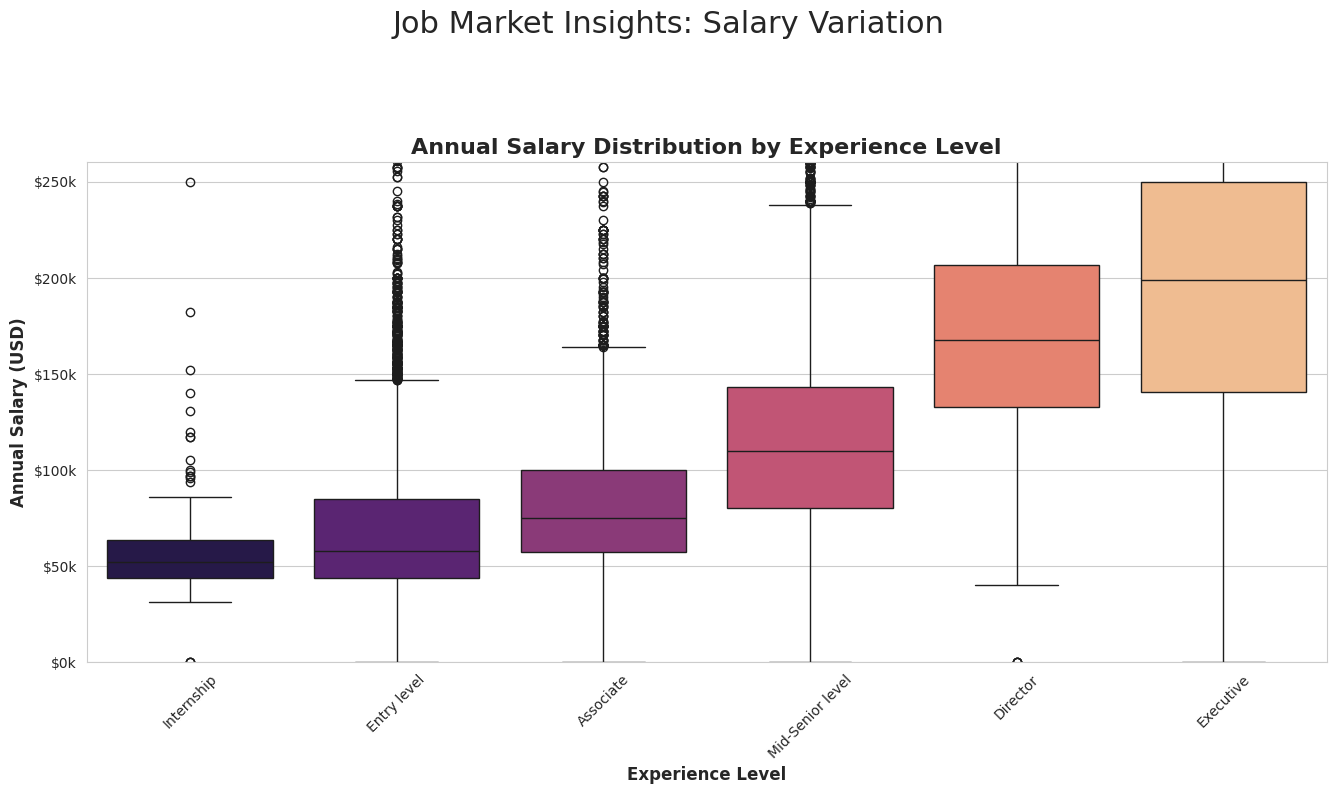

In [138]:
# Advanced Visualization - Salary Distribution by Experience Level

# Data Preparation.
df_salary_dist = postings_full[['formatted_experience_level', 'annual_salary']].dropna()

# Define logical order for experience levels.
experience_order = [
    'Internship',
    'Entry level',
    'Associate',
    'Mid-Senior level',
    'Director',
    'Executive'
]
df_salary_dist = df_salary_dist[df_salary_dist['formatted_experience_level'].isin(experience_order)]

# Create the Box Plot.
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='formatted_experience_level',
    y='annual_salary',
    data=df_salary_dist,
    order=experience_order,
    palette='magma'
)

# Formatting and Labels.
plt.title('Annual Salary Distribution by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Annual Salary (USD)', fontsize=12)
plt.xticks(rotation=45)

# Set y-axis limit to exclude extreme outliers.
quantile_98 = postings_full['annual_salary'].quantile(0.98)
plt.ylim(0, quantile_98)

# Format y-axis to show currency with 'k'.
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'${y/1000:,.0f}k'))

plt.suptitle('Job Market Insights: Salary Variation', fontsize=22, y=1.02)
plt.tight_layout(pad=3.0)
plt.show()

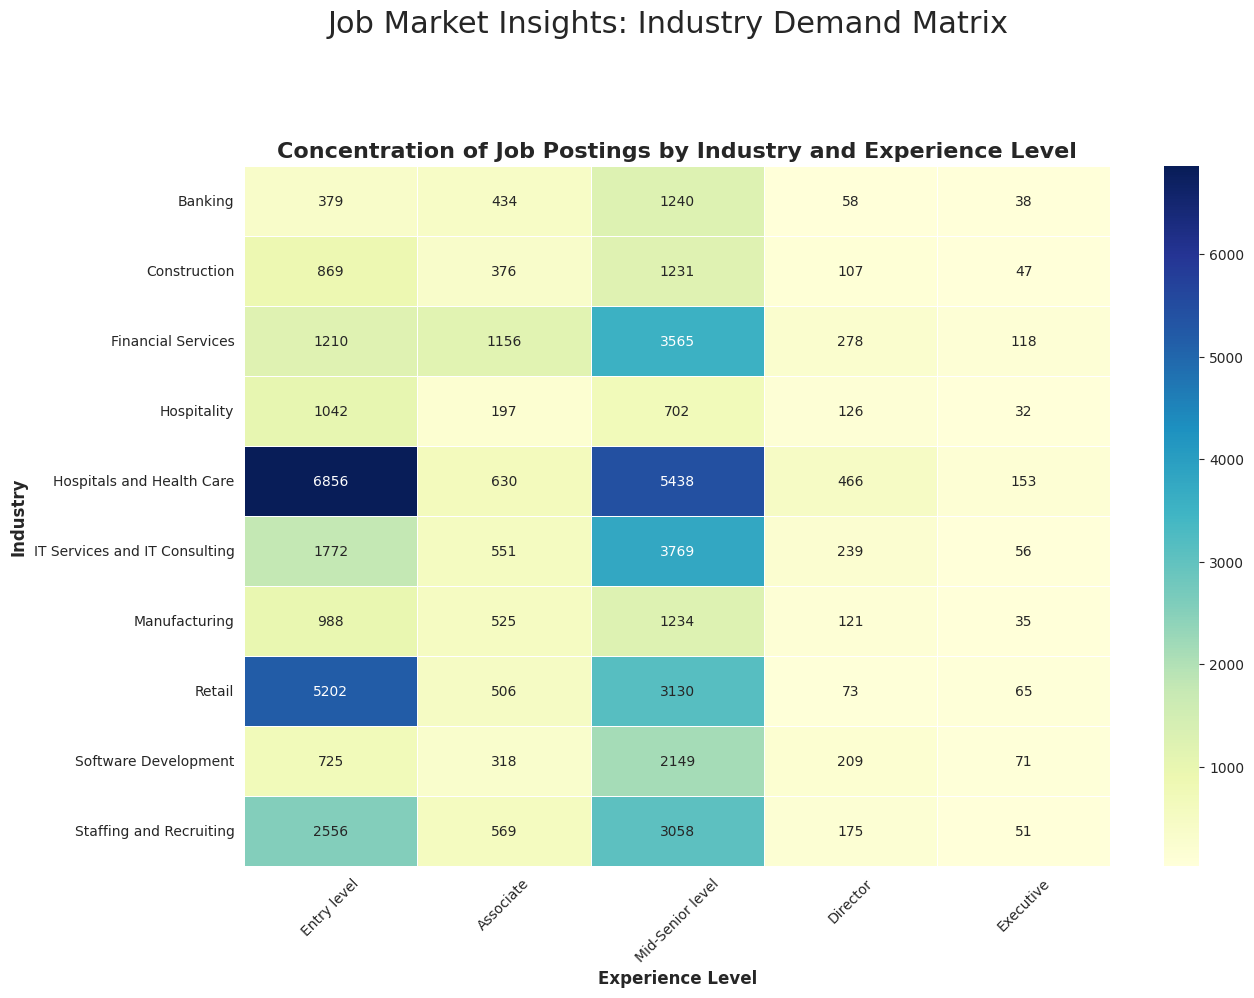

In [139]:
# Advanced Visualization - Heatmap of Job Postings by Industry and Experience Level

# Data Preparation.
df_heatmap = postings_full[['industries_list', 'formatted_experience_level']].dropna()

# Split comma-separated industries.
df_heatmap = df_heatmap.assign(industries_list=df_heatmap['industries_list'].str.split(', ')).explode('industries_list')

# Focus on top 10 industries and main experience levels.
top_10_industries = df_heatmap['industries_list'].value_counts().nlargest(10).index
experience_order = ['Entry level', 'Associate', 'Mid-Senior level', 'Director', 'Executive']

df_heatmap_filtered = df_heatmap[
    df_heatmap['industries_list'].isin(top_10_industries) &
    df_heatmap['formatted_experience_level'].isin(experience_order)
]

# Create a Crosstab.
crosstab_df = pd.crosstab(
    index=df_heatmap_filtered['industries_list'],
    columns=df_heatmap_filtered['formatted_experience_level']
)

# Reorder columns by experience level.
crosstab_df = crosstab_df[experience_order]

# Create the Heatmap.
plt.figure(figsize=(14, 10))
sns.heatmap(
    crosstab_df,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    linewidths=.5
)

# Formatting and Labels.
plt.title('Concentration of Job Postings by Industry and Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Industry', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.suptitle('Job Market Insights: Industry Demand Matrix', fontsize=22, y=1.02)
plt.tight_layout(pad=3.0)
plt.show()

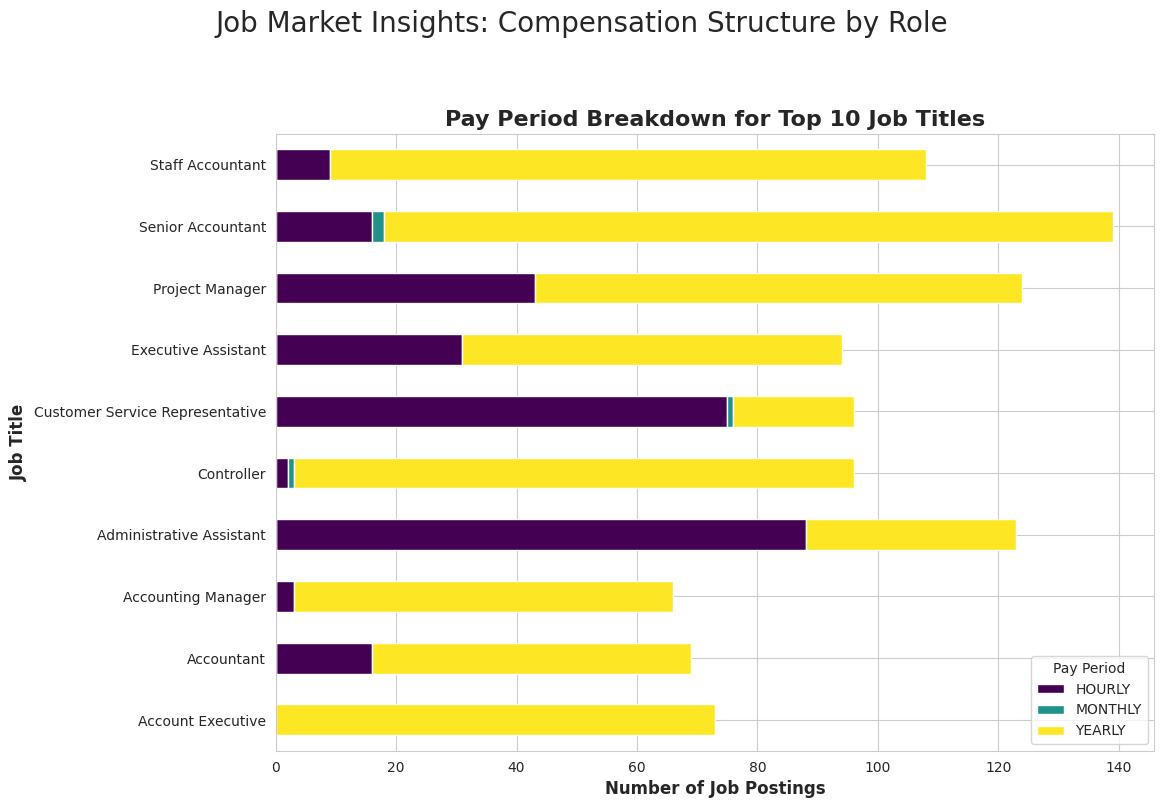

In [140]:
# Analysis of Compensation Pay Periods by Top Job Roles

# Data Preparation.
df_job_pay = postings_full[['title', 'pay_period']].dropna()

# Identify top 10 job titles.
top_10_titles = df_job_pay['title'].value_counts().nlargest(10).index

# Filter for top 10 job titles.
df_top_jobs_pay = df_job_pay[df_job_pay['title'].isin(top_10_titles)]

# Create a Crosstab of pay periods by job title.
pay_period_crosstab = pd.crosstab(
    index=df_top_jobs_pay['title'],
    columns=df_top_jobs_pay['pay_period']
)

# Create the Stacked Bar Chart.
pay_period_crosstab.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    colormap='viridis'
)

# Formatting and Labels.
plt.title('Pay Period Breakdown for Top 10 Job Titles', fontsize=16)
plt.xlabel('Number of Job Postings', fontsize=12)
plt.ylabel('Job Title', fontsize=12)
plt.legend(title='Pay Period')

# Format x-axis with 'k' formatter.
plt.gca().xaxis.set_major_formatter(FuncFormatter(k_formatter))

plt.suptitle('Job Market Insights: Compensation Structure by Role', fontsize=20, y=1.02)
plt.tight_layout(pad=2.0)
plt.show()

In [141]:
# Comprehensive Interactive Dashboard by Job Role

# Import necessary libraries.
import plotly.graph_objects as go
from ipywidgets import Dropdown, VBox, HBox

# Prepare Data for the Dashboard.
# Create list of top 50 job titles for dropdown.
top_50_titles = postings_full['title'].value_counts().nlargest(50).index.tolist()
job_title_list = ['All Roles'] + sorted(top_50_titles)

# Add state map for converting abbreviations to full names.
state_map = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire',
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
    'DC': 'District of Columbia', 'PR': 'Puerto Rico'
}

# Create Initial Figures as FigureWidgets.
# Chart 1: Salary Distribution (Box Plot).
fig_salary = go.FigureWidget(go.Box(
    y=postings_full['annual_salary'].dropna(),
    name='Salary Distribution',
    marker_color='royalblue'
))
fig_salary.update_layout(
    title_text='Salary Distribution for All Roles',
    yaxis_title='Annual Salary (USD)',
    margin=dict(l=20, r=20, t=50, b=20)
)

# Chart 2: Top States.
top_states_initial = postings_full[postings_full['state'].isin(state_map.keys())]['state'].value_counts().nlargest(10) # Filter using keys
top_states_initial.index = [state_map.get(abbr, abbr) for abbr in top_states_initial.index]
fig_states = go.FigureWidget(go.Bar(
    x=top_states_initial.values,
    y=top_states_initial.index,
    orientation='h',
    marker_color='crimson'
))
fig_states.update_layout(
    title_text='Top 10 States for All Roles',
    yaxis={'autorange': 'reversed'},
    margin=dict(l=150, r=20, t=50, b=50)
)

# Chart 3: Top Companies.
top_companies_initial = postings_full[postings_full['company_name'] != 'Unknown Company']['company_name'].value_counts().nlargest(10)
fig_companies = go.FigureWidget(go.Bar(
    x=top_companies_initial.values,
    y=top_companies_initial.index,
    orientation='h',
    marker_color='green'
))
fig_companies.update_layout(
    title_text='Top 10 Companies for All Roles',
    yaxis={'autorange': 'reversed'},
    margin=dict(l=150, r=20, t=50, b=50)
)

# Chart 4: Top Skills.
top_skills_initial = postings_full[postings_full['skills_list'] != 'Not specified']['skills_list'].str.split(', ').explode().value_counts().nlargest(10)
fig_skills = go.FigureWidget(go.Bar(
    x=top_skills_initial.values,
    y=top_skills_initial.index,
    orientation='h',
    marker_color='goldenrod'
))
fig_skills.update_layout(
    title_text='Top 10 Skills for All Roles',
    yaxis={'autorange': 'reversed'},
    margin=dict(l=150, r=20, t=50, b=50)
)

# Create the Dropdown Widget.
job_dropdown = Dropdown(options=job_title_list, description='Select Job Role:')

# Define the Update Function.
def update_dashboard(change):
    selected_role = change.new

    # Filter data based on selection.
    if selected_role == 'All Roles':
        df_filtered = postings_full
    else:
        df_filtered = postings_full[postings_full['title'] == selected_role]

    # Calculate new data for each chart.
    new_salary_data = df_filtered['annual_salary'].dropna()
    new_states_data = df_filtered[df_filtered['state'].isin(state_map.keys())]['state'].value_counts().nlargest(10) # Filter using keys
    new_states_data.index = [state_map.get(abbr, abbr) for abbr in new_states_data.index]
    new_companies_data = df_filtered[df_filtered['company_name'] != 'Unknown Company']['company_name'].value_counts().nlargest(10)
    new_skills_data = df_filtered[df_filtered['skills_list'] != 'Not specified']['skills_list'].str.split(', ').explode().value_counts().nlargest(10)

    # Update charts using batch_update.
    with fig_salary.batch_update(), fig_states.batch_update(), fig_companies.batch_update(), fig_skills.batch_update():
        fig_salary.data[0].y = new_salary_data
        fig_salary.layout.title.text = f'Salary Distribution for {selected_role}'

        fig_states.data[0].x = new_states_data.values
        fig_states.data[0].y = new_states_data.index
        fig_states.layout.title.text = f'Top 10 States for {selected_role}'

        fig_companies.data[0].x = new_companies_data.values
        fig_companies.data[0].y = new_companies_data.index
        fig_companies.layout.title.text = f'Top 10 Companies for {selected_role}'

        fig_skills.data[0].x = new_skills_data.values
        fig_skills.data[0].y = new_skills_data.index
        fig_skills.layout.title.text = f'Top 10 Skills for {selected_role}'

# Link Dropdown to Update Function.
job_dropdown.observe(update_dashboard, names='value')

# Display the Dashboard.
dashboard = VBox([
    job_dropdown,
    HBox([fig_salary, fig_states]),
    HBox([fig_companies, fig_skills])
])
dashboard

## Key Insights from the LinkedIn Job Postings Analysis

Based on the exploratory data analysis, natural language processing, and machine learning performed on the LinkedIn job postings dataset, here are the key insights into the digital job market:

### Overall Job Market Overview

*   **Experience Level Distribution:** The majority of job postings are for **Mid-Senior level** and **Entry level** positions, indicating a strong demand for both experienced professionals and those starting their careers.
*   **Top Job Titles:** The most common job titles reflect a diverse market, with roles like **Sales Manager**, **Customer Service Representative**, and **Project Manager** appearing frequently.
*   **Employment Type:** **Full-time** positions dominate the job market, although there are also opportunities for contract, part-time, and temporary roles.
*   **Remote Work:** A significant portion of job postings **do not allow remote work**, with only a smaller percentage explicitly indicating remote options.

### Industry and Skills Analysis

*   **Top Industries:** The **Hospitals and Health Care**, **Retail**, and **IT Services and IT Consulting** sectors have the highest number of job postings, suggesting robust hiring in these areas.
*   **In-Demand Skills:** The word cloud highlights key skills sought by employers, including **Information Technology**, **Sales**, **Management**, **Manufacturing**, and **Health Care Provider**.

### Salary Analysis

*   **Salary Distribution:** The distribution of annual salaries shows a wide range, with a concentration of postings in the **\$50k to \$100k** range.
*   **Salary by Experience Level:** As expected, there is a clear correlation between experience level and median annual salary, with **Executive** and **Director** level positions commanding the highest median salaries. **Internship** and **Entry level** positions have the lowest median salaries.
*   **Salary by Company Size:** The median annual salary generally **increases with company size**, with companies having over 10,000 employees offering the highest median salaries.

### Geographical Analysis

*   **Top States for Job Postings:** **California**, **Texas**, and **New York** lead the United States in the number of LinkedIn job postings, indicating these states are major job markets.

### Natural Language Processing Insights

*   **Common Phrases in Job Descriptions:** Analysis of job descriptions reveals frequently used phrases related to **equal opportunity**, **experience requirements**, **customer service**, and **teamwork**. This provides insight into common hiring criteria and workplace expectations.

### Job Clustering

*   **Job Categories:** Clustering of job descriptions reveals distinct categories such as **Technical/Engineering**, **Business/Sales**, **Retail/Customer Service**, **General/Administrative**, and **Healthcare**, indicating specialization within the job market.

### Compensation Structure

*   **Pay Period Breakdown:** The analysis of pay periods for top job titles shows that **YEARLY** salaries are the most common, followed by **HOURLY** wages.

### Machine Learning Model (Salary Prediction)

*   **Feature Importance:** The Machine Learning model for predicting annual salary highlights that **Experience Level** is the most important factor, followed by **Company Size** and **State**.

These insights provide a comprehensive overview of the LinkedIn job market, highlighting trends in demand, compensation, location, and key skills.